NBA/WNBA Player Salaries Analysis

In [14]:
!pip install openpyxl==3.0.9
!pip install unidecode

In [15]:
!pip install yellowbrick
!pip install scikit-learn
!pip install statsmodels

In [16]:
#to allow Colab to get files from Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [17]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode

from yellowbrick.regressor import CooksDistance
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

In [18]:
#set display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Data Cleaning

In [19]:
#load in data
#nba_bios = pd.read_excel('drive/My Drive/DSCI531_FinalProject/data/nba_players_bios.xlsx', index_col=None)
#nba_contracts = pd.read_excel('drive/My Drive/DSCI531_FinalProject/data/nba_players_contracts.xlsx', index_col=None)
#wnba_bios = pd.read_excel('drive/My Drive/DSCI531_FinalProject/data/wnba_players_bios.xlsx', index_col=None)
#wnba_contracts = pd.read_excel('drive/My Drive/DSCI531_FinalProject/data/wnba_players_contracts.xlsx', index_col=None)

nba_bios = pd.read_excel('../data/nba_players_bios.xlsx', index_col=None)
nba_contracts = pd.read_excel('../data/nba_players_contracts.xlsx', index_col=None)
wnba_bios = pd.read_excel('../data/wnba_players_bios.xlsx', index_col=None)
wnba_contracts = pd.read_excel('../data/wnba_players_contracts.xlsx', index_col=None)

In [20]:
#fix Player name in nba_contracts
nba_contracts['Player'] = nba_contracts['Player'].apply(lambda x: x.split('\\')[0])

#remove accents from names (i.e. Kristaps Porzingis)
nba_bios['Player'] = nba_bios['Player'].apply(lambda x: unidecode.unidecode(x))
nba_contracts['Player'] = nba_contracts['Player'].apply(lambda x: unidecode.unidecode(x))
wnba_bios['Player'] = wnba_bios['Player'].apply(lambda x: unidecode.unidecode(x))
wnba_contracts['Player'] = wnba_contracts['Player'].apply(lambda x: unidecode.unidecode(x))

#remove whitespace from Player names
nba_bios['Player'] = nba_bios['Player'].str.strip()
nba_contracts['Player'] = nba_contracts['Player'].str.strip()
wnba_bios['Player'] = wnba_bios['Player'].str.strip()
wnba_contracts['Player'] = wnba_contracts['Player'].str.strip()

In [21]:
#remove duplicate names in contracts
##first remove rows w/o 2021 Salary
nba_contracts = nba_contracts.dropna(subset=['2021-22'])
##for the duplicate Player names, keep the row w/ highest 2021 Salary value
##sort by salary first
nba_contracts = nba_contracts.sort_values(by=['2021-22', 'Player'], ascending=False)
nba_contracts = nba_contracts.drop_duplicates(subset='Player', keep='first')
nba_contracts = nba_contracts.reset_index(drop=True)

##first remove rows w/o 2021 Salary
wnba_contracts = wnba_contracts.dropna(subset=['2021 Salary'])
##for the duplicate Player names, keep the row w/ highest 2021 Salary value
##sort by salary first
wnba_contracts = wnba_contracts.sort_values(by=['2021 Salary', 'Player'], ascending=False)
wnba_contracts = wnba_contracts.drop_duplicates(subset='Player', keep='first')
wnba_contracts = wnba_contracts.reset_index(drop=True)

In [22]:
#convert feet-inches to inches
def convert_height(x):
    #ex: 6-11
    height = x.split('-')
    feet = int(height[0])
    inches = int(height[1])
    return (feet*12) + inches

nba_bios['Height'] = nba_bios['Height'].apply(convert_height)
wnba_bios['Height'] = wnba_bios['Height'].apply(convert_height)

In [23]:
#delete extra columns
wnba_contracts = wnba_contracts.iloc[:,:3]
nba_contracts = nba_contracts.drop('Rk', axis=1)
nba_contracts = nba_contracts.iloc[:,[0,1,2,8]]

In [24]:
#create column for USA or International player
nba_bios['USA_Int'] = ''
nba_bios.loc[(nba_bios.Country == 'USA'), 'USA_Int'] = 'USA'
nba_bios.loc[(nba_bios.Country != 'USA'), 'USA_Int'] = 'Int'

wnba_bios['USA_Int'] = ''
wnba_bios.loc[(wnba_bios.Country == 'USA'), 'USA_Int'] = 'USA'
wnba_bios.loc[(wnba_bios.Country != 'USA'), 'USA_Int'] = 'Int'

In [25]:
#join bios and contracts
nba_final = nba_contracts.merge(nba_bios, how='left', on='Player')
wnba_final = wnba_contracts.merge(wnba_bios, how='left', on='Player')

print(nba_final.head()) #players who have not played this current season have no nba_bios data (ex. John Wall)
print(wnba_final.head())

              Player   Tm      2021-22 Signed Using Team    Age  Height  \
0      Stephen Curry  GSW 45780966.000  Bird Rights  GSW 33.000  74.000   
1          John Wall  HOU 44310840.000  Bird Rights  NaN    NaN     NaN   
2  Russell Westbrook  LAL 44211146.000  Bird Rights  LAL 33.000  75.000   
3       James Harden  BRK 43848000.000  Bird Rights  BKN 32.000  77.000   
4       LeBron James  LAL 41180544.000         Bird  LAL 37.000  81.000   

   Weight        College Country  ...    PTS   REB    AST  NetRtg  OREB%  \
0 185.000       Davidson     USA  ... 26.000 5.500  6.300  13.600  0.018   
1     NaN            NaN     NaN  ...    NaN   NaN    NaN     NaN    NaN   
2 200.000           UCLA     USA  ... 18.700 7.900  7.800  -3.000  0.037   
3 220.000  Arizona State     USA  ... 22.500 8.000 10.200   0.600  0.026   
4 250.000           None     USA  ... 29.100 7.700  6.300  -0.300  0.030   

   DREB%  USG%   TS%  AST%  USA_Int  
0  0.127 0.301 0.586 0.284      USA  
1    NaN   NaN  

Exploratory Analysis (figures we want to include)

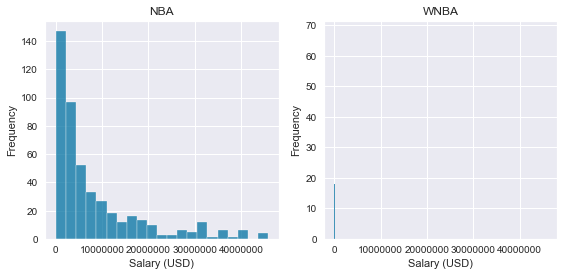

In [26]:
#Histogram of Player Salaries
sns.set_style("darkgrid")
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4),sharex=True) ################can add this one to the presentation instead of the paper

#ax1.ticklabel_format(style='plain', axis='both') #remove scientific notation
p1 = sns.histplot(x='2021-22', data=nba_final, ax=ax1)
p1.set(title='NBA', xlabel='Salary (USD)', ylabel='Frequency')

ax2.ticklabel_format(style='plain', axis='both')
p2 = sns.histplot(x='2021 Salary', data=wnba_final, ax=ax2)
p2.set(title='WNBA', xlabel='Salary (USD)', ylabel='Frequency')

#plt.suptitle('Histogram of Player Salaries')
plt.tight_layout()
#plt.savefig('drive/My Drive/DSCI531_FinalProject/images/histogram_salaries_sharedaxis.png')
plt.savefig('../images/histogram_salaries_sharedaxis.png')
plt.show()

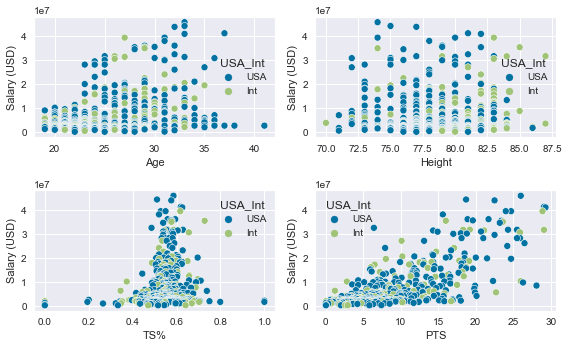

In [27]:
#Histogram of Player Salaries
sns.set_style("darkgrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,5))

p1 = sns.scatterplot(x='Age', y='2021-22', hue='USA_Int', data=nba_final, ax=ax1)
p1.set(ylabel='Salary (USD)')

p2 = sns.scatterplot(x='Height', y='2021-22', hue='USA_Int', data=nba_final, ax=ax2)
p2.set(ylabel='Salary (USD)')

p3 = sns.scatterplot(x='TS%', y='2021-22', hue='USA_Int', data=nba_final, ax=ax3)
p3.set(ylabel='Salary (USD)')

p4 = sns.scatterplot(x='PTS', y='2021-22', hue='USA_Int', data=nba_final, ax=ax4)
p4.set(ylabel='Salary (USD)')

#plt.suptitle('Scatterplots of NBA Player Attributes')
plt.tight_layout()
#plt.savefig('drive/My Drive/DSCI531_FinalProject/images/scatterplot_features.png')
plt.savefig('../images/scatterplot_features.png')
plt.show()

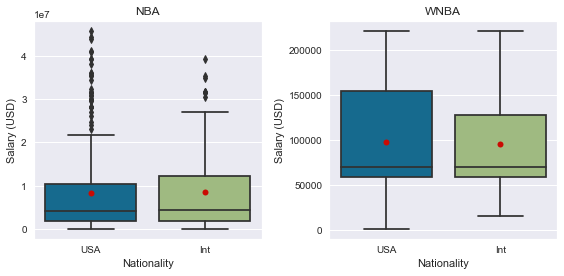

In [28]:
#Boxplot of Player Salaries by USA/INT
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

#ax1.ticklabel_format(style='plain', axis='both') #remove scientific notation
p1 = sns.boxplot(x="USA_Int", y="2021-22", data=nba_final, ax=ax1, showmeans=True, meanprops={"marker":"o"})
p1.set(title='NBA', xlabel='Nationality', ylabel='Salary (USD)')

#ax2.ticklabel_format(style='plain', axis='both') #remove scientific notation
p2 = sns.boxplot(x="USA_Int", y="2021 Salary", data=wnba_final, ax=ax2, showmeans=True, meanprops={"marker":"o"})
p2.set(title='WNBA', xlabel='Nationality', ylabel='Salary (USD)')

#plt.suptitle('Boxplot of Player Salaries by Nationality')
plt.tight_layout()
#plt.savefig('drive/My Drive/DSCI531_FinalProject/images/boxplot_salaries.png')
plt.savefig('../images/boxplot_salaries.png')
plt.show()

In [29]:
nba_final.groupby('USA_Int').mean()['2021-22'] #seemingly no difference between USA and Int salaries

USA_Int
Int   8564557.682
USA   8345935.902
Name: 2021-22, dtype: float64

In [30]:
wnba_final.groupby('USA_Int').mean()['2021 Salary'] #seemingly no difference between USA and Int salaries

USA_Int
Int   95624.500
USA   97611.554
Name: 2021 Salary, dtype: float64

In [31]:
print(nba_final['USA_Int'].value_counts())
print(wnba_final['USA_Int'].value_counts())

USA    325
Int    110
Name: USA_Int, dtype: int64
USA    139
Int     16
Name: USA_Int, dtype: int64


In [32]:
# Map USA_Int to bool
d = {'USA': 0, 'Int': 1}
nba_final['USA_Int'] = nba_final['USA_Int'].map(d)
wnba_final['USA_Int'] = wnba_final['USA_Int'].map(d)

In [33]:
#T-test to see if salary is significantly different for USA vs Int
print(stats.ttest_ind(nba_final[nba_final['USA_Int'] == 1]['2021-22'], nba_final[nba_final['USA_Int'] == 0]['2021-22']))
print(stats.ttest_ind(wnba_final[wnba_final['USA_Int'] == 1]['2021 Salary'], wnba_final[wnba_final['USA_Int'] == 0]['2021 Salary']))

Ttest_indResult(statistic=0.20646624616615616, pvalue=0.8365237758865895)
Ttest_indResult(statistic=-0.12033774543029332, pvalue=0.9043734853547665)


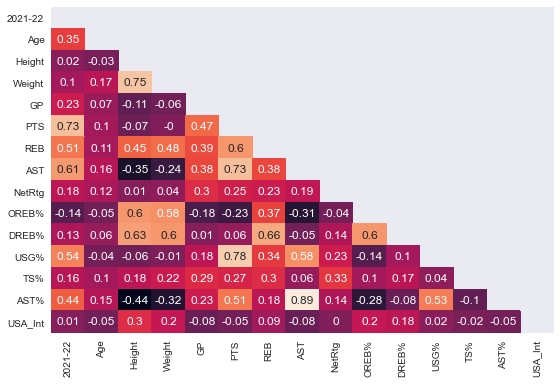

In [34]:
#Correlation Matrix of Player Attributes
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (9,6)

corrMatrix1 = nba_final[['2021-22','Age','Height','Weight','GP','PTS','REB','AST','NetRtg','OREB%','DREB%','USG%','TS%','AST%','USA_Int']].corr()
triu1 = np.triu(corrMatrix1) #show only half of the matrix
p1 = sns.heatmap(corrMatrix1.round(2), annot=True, cbar=False, mask=triu1)
#p1.set(title='Correlation Matrix of NBA Player Attributes')

#plt.suptitle('Correlation Matrix of Player Attributes')
#plt.savefig('drive/My Drive/DSCI531_FinalProject/images/nba_correlation_matrix_features.png')
plt.savefig('../images/nba_correlation_matrix_features.png')
plt.show()

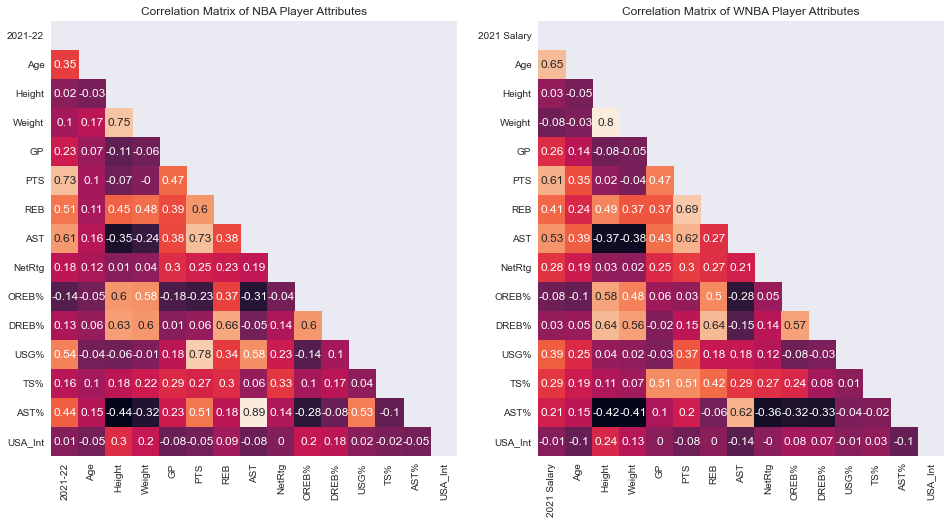

In [35]:
#Correlation Matrix of Player Attributes
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

corrMatrix1 = nba_final[['2021-22','Age','Height','Weight','GP','PTS','REB','AST','NetRtg','OREB%','DREB%','USG%','TS%','AST%','USA_Int']].corr()
triu1 = np.triu(corrMatrix1) #show only half of the matrix
p1 = sns.heatmap(corrMatrix1.round(2), annot=True, cbar=False, mask=triu1, ax=ax1)
p1.set(title='Correlation Matrix of NBA Player Attributes')

corrMatrix2 = wnba_final[['2021 Salary','Age','Height','Weight','GP','PTS','REB','AST','NetRtg','OREB%','DREB%','USG%','TS%','AST%','USA_Int']].corr()
triu2 = np.triu(corrMatrix2)
p2 = sns.heatmap(corrMatrix2.round(2), annot=True, cbar=False, mask=triu2, ax=ax2)
p2.set(title='Correlation Matrix of WNBA Player Attributes')

#plt.suptitle('Correlation Matrix of Player Attributes')
#plt.savefig('drive/My Drive/DSCI531_FinalProject/images/correlation_matrix_features.png')
plt.savefig('../images/correlation_matrix_features.png')
plt.show()

Modeling

In [36]:
nba_final.head()

,Player,Tm,2021-22,Signed Using,Team,Age,Height,Weight,College,Country,...,PTS,REB,AST,NetRtg,OREB%,DREB%,USG%,TS%,AST%,USA_Int
0,Stephen Curry,GSW,45780966.000,Bird Rights,GSW,33.000,74.000,185.000,Davidson,USA,...,26.000,5.500,6.300,13.600,0.018,0.127,0.301,0.586,0.284,0.000
1,John Wall,HOU,44310840.000,Bird Rights,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Russell Westbrook,LAL,44211146.000,Bird Rights,LAL,33.000,75.000,200.000,UCLA,USA,...,18.700,7.900,7.800,-3.000,0.037,0.173,0.267,0.511,0.343,0.000
3,James Harden,BRK,43848000.000,Bird Rights,BKN,32.000,77.000,220.000,Arizona State,USA,...,22.500,8.000,10.200,0.600,0.026,0.179,0.277,0.576,0.399,0.000
4,LeBron James,LAL,41180544.000,Bird,LAL,37.000,81.000,250.000,None,USA,...,29.100,7.700,6.300,-0.300,0.030,0.172,0.306,0.619,0.301,0.000


In [37]:
wnba_final.head()

,Player,2021 Salary,2021 Signing,Team,Age,Height,Weight,College,Country,GP,PTS,REB,AST,NetRtg,OREB%,DREB%,USG%,TS%,AST%,USA_Int
0,Sue Bird,221450.000,UFA,SEA,41.000,69.000,150.000,Connecticut,USA,30.000,10.000,2.600,5.300,6.400,0.010,0.082,0.164,0.583,0.302,0.000
1,Skylar Diggins-Smith,221450.000,--,PHO,31.000,69.000,145.000,Notre Dame,USA,32.000,17.700,3.200,5.300,7.600,0.018,0.073,0.238,0.591,0.275,0.000
2,Liz Cambage,221450.000,Core,LVA,30.000,80.000,216.000,None,Australia,25.000,14.200,8.200,1.300,13.200,0.070,0.250,0.248,0.589,0.094,1.000
3,Elena Delle Donne,221450.000,--,WAS,32.000,77.000,187.000,Delaware,USA,3.000,13.700,4.300,0.700,29.600,0.057,0.175,0.276,0.635,0.071,0.000
4,Diana Taurasi,221450.000,UFA,PHO,39.000,72.000,163.000,Connecticut,USA,16.000,15.200,4.400,4.900,6.600,0.007,0.136,0.255,0.543,0.276,0.000


In [38]:
# # Map USA_Int to bool
# d = {'USA': 0, 'Int': 1}
# nba_final['USA_Int'] = nba_final['USA_Int'].map(d)
# wnba_final['USA_Int'] = wnba_final['USA_Int'].map(d)

In [39]:
"""
---------- PRELIM MODEL TESTING ----------
"""

'\n---------- PRELIM MODEL TESTING ----------\n'

In [40]:
# # Map USA_Int to bool
# d = {'USA': 0, 'Int': 1}
# nba_final['USA_Int'] = nba_final['USA_Int'].map(d)
# wnba_final['USA_Int'] = wnba_final['USA_Int'].map(d)

In [41]:
# ---------- Feature Dist for NBA ----------
# Set up table vectors
var_name = ['Age', 'Height', 'Weight', 'GP', 'PTS', 'REB', 'AST', 'NetRtg', 'OREB%', 'DREB%', 'USG%', 'TS%', 'AST%']
var_mean = list(); var_median = list(); var_range = list()
var_1quart = list(); var_3quart = list(); var_IQR = list()

# Find various stats for each variable (mean, median, range, 1st/3rd quartile, IQR), store in table vectors
for col in var_name:
    var_mean.append(nba_final[col].mean())
    var_median.append(nba_final[col].median())
    var_range.append((nba_final[col].max() - nba_final[col].min()))

    q1 = nba_final[col].quantile(q=0.25)
    q3 = nba_final[col].quantile(q=0.75)
    var_1quart.append(q1)
    var_3quart.append(q3)
    var_IQR.append((q3-q1))

# Create table to show values
comp_data = {'Variable Name': var_name,
             'Mean': var_mean,
             'Median': var_median,
             'Range': var_range,
             '1st Quartile': var_1quart,
             '3rd Quartile': var_3quart,
             'Interquartile Range': var_IQR}
comp_df = pd.DataFrame(comp_data, columns=['Variable Name', 'Mean', 'Median', 'Range',
                                           '1st Quartile', '3rd Quartile', 'Interquartile Range'])
comp_df

,Variable Name,Mean,Median,Range,1st Quartile,3rd Quartile,Interquartile Range
0,Age,26.136,25.000,22.000,22.500,29.000,6.500
1,Height,78.421,78.000,17.000,76.000,81.000,5.000
2,Weight,216.474,215.000,130.000,200.000,232.000,32.000
3,GP,34.986,38.000,52.000,27.000,45.000,18.000
4,PTS,9.657,8.000,29.300,5.050,13.300,8.250
5,REB,4.026,3.500,15.100,2.300,5.000,2.700
6,AST,2.129,1.400,10.500,0.800,2.700,1.900
7,NetRtg,-2.093,-0.300,273.400,-5.650,3.950,9.600
8,OREB%,0.046,0.033,0.286,0.019,0.062,0.043
9,DREB%,0.138,0.124,0.389,0.096,0.171,0.075


In [42]:
# ---------- Feature Dist for WNBA ----------
# Set up table vectors
var_name = ['Age', 'Height', 'Weight', 'GP', 'PTS', 'REB', 'AST', 'NetRtg', 'OREB%', 'DREB%', 'USG%', 'TS%', 'AST%']
var_mean = list(); var_median = list(); var_range = list()
var_1quart = list(); var_3quart = list(); var_IQR = list()

# Find various stats for each variable (mean, median, range, 1st/3rd quartile, IQR), store in table vectors
for col in var_name:
    var_mean.append(wnba_final[col].mean())
    var_median.append(wnba_final[col].median())
    var_range.append((wnba_final[col].max() - wnba_final[col].min()))

    q1 = wnba_final[col].quantile(q=0.25)
    q3 = wnba_final[col].quantile(q=0.75)
    var_1quart.append(q1)
    var_3quart.append(q3)
    var_IQR.append((q3-q1))

# Create table to show values
comp_data = {'Variable Name': var_name,
             'Mean': var_mean,
             'Median': var_median,
             'Range': var_range,
             '1st Quartile': var_1quart,
             '3rd Quartile': var_3quart,
             'Interquartile Range': var_IQR}
comp_df = pd.DataFrame(comp_data, columns=['Variable Name', 'Mean', 'Median', 'Range',
                                           '1st Quartile', '3rd Quartile', 'Interquartile Range'])
comp_df

,Variable Name,Mean,Median,Range,1st Quartile,3rd Quartile,Interquartile Range
0,Age,27.258,27.000,21.000,24.000,29.000,5.000
1,Height,72.503,73.000,17.000,69.000,75.000,6.000
2,Weight,172.548,170.000,122.000,159.000,188.000,29.000
3,GP,23.000,27.000,31.000,17.500,31.000,13.500
4,PTS,7.651,6.400,23.400,3.250,11.450,8.200
5,REB,3.384,3.000,11.200,1.600,4.300,2.700
6,AST,1.775,1.400,8.600,0.750,2.500,1.750
7,NetRtg,-2.926,-2.800,189.700,-8.400,5.350,13.750
8,OREB%,0.041,0.031,0.125,0.017,0.065,0.048
9,DREB%,0.131,0.121,0.375,0.085,0.172,0.087


In [43]:
"""
---------- NBA ----------
"""

'\n---------- NBA ----------\n'

In [44]:
# Separate features from label
nba_trimmed = nba_final.dropna()
nba_features = ['Age', 'Height', 'Weight', 'GP', 'PTS', 'REB', 'AST', 'NetRtg', 'OREB%', 'DREB%', 'USG%', 'TS%', 'AST%', 'USA_Int']
x = nba_trimmed[nba_features]
y = nba_trimmed['2021-22']

# Create subsets of train/test data
all_x_train, all_x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=24)

In [45]:
# wnba_trimmed = wnba_final.dropna()
# together = wnba_trimmed[['2021 Salary', 'Age', 'Height', 'Weight', 'GP', 'PTS', 'REB', 'AST', 'NetRtg', 'OREB%', 'DREB%', 'USG%', 'TS%', 'AST%', 'USA_Int']]
# together

In [46]:
# ---------- Simple Linear Reg, single feature test ----------
test_coef = list()
test_MSE = list()
test_r2 = list()

# Iterate through features, creating models and saving fit metrics
model = LinearRegression()  # initiate model

for var in nba_features:
    x_train = all_x_train[var]  # select wanted feature
    x_test = all_x_test[var]

    x_train = x_train.to_numpy()  # conversion to np array for sklearn (adapted from HW1)
    x_test = x_test.to_numpy()

    x_train = x_train.reshape(-1, 1)  # throws an error without including this to turn the 1D array into 2D
    x_test = x_test.reshape(-1, 1)

    model.fit(x_train, y_train)  # fit the model to training data
    y_pred = model.predict(x_test)  # create prediction y for later comparison

    test_coef.append(float(model.coef_))
    test_MSE.append(metrics.mean_squared_error(y_test, y_pred))
    test_r2.append(metrics.r2_score(y_test, y_pred))

# Create table to show values
comp_data = {'Feature Tested': nba_features,
             'Coefficient': test_coef,
             'Mean Squared Error': test_MSE,
             'R^2 Value': test_r2}
comp_df = pd.DataFrame(comp_data, columns=['Feature Tested', 'Coefficient', 'Mean Squared Error', 'R^2 Value'])
comp_df

,Feature Tested,Coefficient,Mean Squared Error,R^2 Value
0,Age,811335.862,86790626109263.703,0.095
1,Height,90042.873,99184070877645.891,-0.034
2,Weight,34565.953,97827692690126.750,-0.020
3,GP,159173.428,96178219290724.875,-0.003
4,PTS,1194134.366,48698070778620.164,0.492
5,REB,1927443.795,76781178038133.453,0.199
6,AST,3395057.352,73658688656681.016,0.232
7,NetRtg,224845.764,92122462557090.562,0.039
8,OREB%,-37663014.521,97268364958163.109,-0.014
9,DREB%,21794265.772,97193320937542.297,-0.014


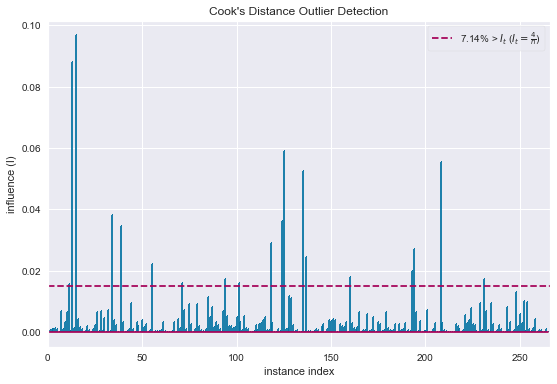

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [47]:
# Identify outliers using yellowbrick Cook's Distance visualizer for training dataset
nba_visualizer = CooksDistance()
nba_visualizer.fit(all_x_train, y_train)
nba_visualizer.show()

In [48]:
# Utilize statsmodels.api functionality for pulling feature p-values
x2_train = sm.add_constant(all_x_train)
est = sm.OLS(y_train, x2_train)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                2021-22   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     39.03
Date:                Mon, 02 May 2022   Prob (F-statistic):           6.75e-55
Time:                        13:21:28   Log-Likelihood:                -4505.4
No. Observations:                 266   AIC:                             9041.
Df Residuals:                     251   BIC:                             9094.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.579e+07   1.44e+07     -1.794      0.0

In [49]:
"""
---------- WNBA ----------
"""

'\n---------- WNBA ----------\n'

In [50]:
# Separate features from label
wnba_trimmed = wnba_final.dropna()
wnba_features = ['Age', 'Height', 'Weight', 'GP', 'PTS', 'REB', 'AST', 'NetRtg', 'OREB%', 'DREB%', 'USG%', 'TS%', 'AST%', 'USA_Int']
x = wnba_trimmed[nba_features]
y = wnba_trimmed['2021 Salary']

# Create subsets of train/test data
all_x_train, all_x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=24)

In [51]:
# ---------- Simple Linear Reg, single feature test ----------
test_coef = list()
test_MSE = list()
test_r2 = list()

# Iterate through features, creating models and saving fit metrics
model = LinearRegression()  # initiate model

for var in nba_features:
    x_train = all_x_train[var]  # select wanted feature
    x_test = all_x_test[var]

    x_train = x_train.to_numpy()  # conversion to np array for sklearn (adapted from HW1)
    x_test = x_test.to_numpy()

    x_train = x_train.reshape(-1, 1)  # throws an error without including this to turn the 1D array into 2D
    x_test = x_test.reshape(-1, 1)

    model.fit(x_train, y_train)  # fit the model to training data
    y_pred = model.predict(x_test)  # create prediction y for later comparison

    test_coef.append(float(model.coef_))
    test_MSE.append(metrics.mean_squared_error(y_test, y_pred))
    test_r2.append(metrics.r2_score(y_test, y_pred))

# Create table to show values
comp_data = {'Feature Tested': nba_features,
             'Coefficient': test_coef,
             'Mean Squared Error': test_MSE,
             'R^2 Value': test_r2}
comp_df = pd.DataFrame(comp_data, columns=['Feature Tested', 'Coefficient', 'Mean Squared Error', 'R^2 Value'])
comp_df

,Feature Tested,Coefficient,Mean Squared Error,R^2 Value
0,Age,10253.014,2522385037.536,0.382
1,Height,1551.592,4179998159.003,-0.025
2,Weight,-97.538,4035144461.117,0.011
3,GP,1113.634,3542157728.412,0.132
4,PTS,7513.136,2596568409.783,0.363
5,REB,10878.788,3368304956.046,0.174
6,AST,23839.731,2449013033.237,0.400
7,NetRtg,1069.394,3831436463.666,0.061
8,OREB%,-156439.810,4052095665.027,0.007
9,DREB%,105478.775,4242466767.692,-0.040


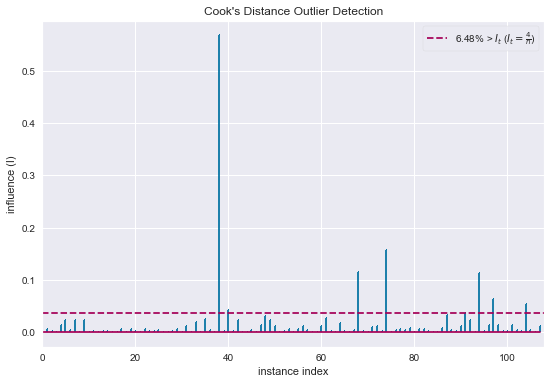

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [52]:
# Identify outliers using yellowbrick Cook's Distance visualizer for training dataset
wnba_visualizer = CooksDistance()
wnba_visualizer.fit(all_x_train, y_train)
wnba_visualizer.show()

In [53]:
# Utilize statsmodels.api functionality for pulling feature p-values
x2_train = sm.add_constant(all_x_train)
est = sm.OLS(y_train, x2_train)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            2021 Salary   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     12.38
Date:                Mon, 02 May 2022   Prob (F-statistic):           1.00e-15
Time:                        13:21:29   Log-Likelihood:                -1287.1
No. Observations:                 108   AIC:                             2604.
Df Residuals:                      93   BIC:                             2644.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.908e+05   1.38e+05     -2.842      0.0

In [54]:
#try a random forest and see variable importance plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Separate features from label
nba_trimmed = nba_final.dropna()
nba_features = ['Age', 'Height', 'Weight', 'GP', 'PTS', 'REB', 'AST', 'NetRtg', 'OREB%', 'DREB%', 'USG%', 'TS%', 'AST%', 'USA_Int']
x = nba_trimmed[nba_features]
y = nba_trimmed['2021-22']

# Create subsets of train/test data
all_x_train, all_x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=24)

In [55]:
# Separate features from label
wnba_trimmed = wnba_final.dropna()
wnba_features = ['Age', 'Height', 'Weight', 'GP', 'PTS', 'REB', 'AST', 'NetRtg', 'OREB%', 'DREB%', 'USG%', 'TS%', 'AST%', 'USA_Int']
x = wnba_trimmed[nba_features]
y = wnba_trimmed['2021 Salary']

# Create subsets of train/test data
all_x_train, all_x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=24)

In [56]:
params = {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 4, 5, 6, 7]}

rf_mod = RandomForestRegressor(random_state=24)

#can use grid search cv with xgboost
grid_search = GridSearchCV(estimator=rf_mod, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(all_x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=24), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [50, 100, 150, 200, 250]})

In [57]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=24)

In [58]:
rf = RandomForestRegressor(n_estimators=50, max_depth=6, random_state=24)
rf.fit(all_x_train, y_train)
print(rf.score(all_x_train,y_train))
print(rf.score(all_x_test,y_test))

0.9315607730034605
0.6627047313042599


In [59]:
y_pred = rf.predict(all_x_train)
np.sqrt(metrics.mean_squared_error(y_train, y_pred)) # RMSE

16057.549732849611

In [60]:
y_pred = rf.predict(all_x_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred)) # RMSE

37092.04386981556

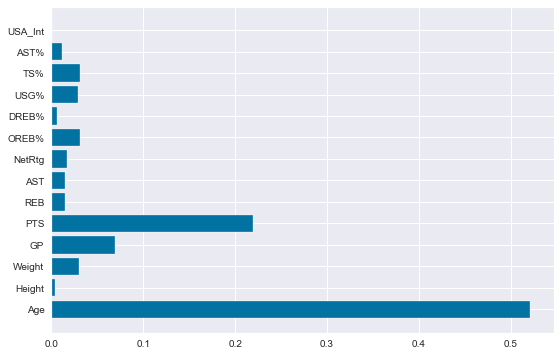

In [61]:
plt.barh(all_x_train.columns, rf.feature_importances_)
plt.show() #PTS and Age have most importance for both NBA and WNBA (NBA: 1-PTS, 2-Age, WNBA: 1-Age, 2-PTS) ######### PTS is actually points per game not total points